In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import sys, os, pickle, time, warnings

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac

from multiprocessing import Pool
import emcee, corner

In [80]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
from transformations import func_inv_jac, func_labels, label_dict

# Load in parameter transformations

In [14]:
# transform, p1, p2, lower bound, upper bound
param_trans = {}
a_dirichlet = 2
param_trans['shd'] = {'alpha1':('nexp',0,0,-3,3,'none'),
                      'alpha2':('nexp',0,0,-3,3,'none')}
param_trans[0] = {'w':('exp',0,0,-10,10,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1, -10,10,'logistic'),
                  'alpha3':('nexp',0,0,-10,10,'none'),
                  'hz': ('logit_scaled', 0,  1.2,-10,10,'logistic')}
param_trans[1] = {'w':('exp',0,0,-10,10,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1,-10,10,'logistic'),
                  'alpha3':('nexp',0,0,-10,10,'none'),
                  'hz': ('logit_scaled', 1.2,3,-10,10,'logistic')}
param_trans[2] = {'w':('exp',0,0,-10,10,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1,-10,10,'logistic'),
                  'alpha3':('nexp',0,0,-10,10,'none'),
                  'hz': ('logit_scaled', 3,  7.3,-10,10,'logistic')}

# Generate model parameters

In [9]:
# Load True Parameters
true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[str(j)]['w']*=1000

In [10]:
fid_pars = {'Mmax':true_pars['Mx'],  'lat_min':np.deg2rad(true_pars['theta_deg']), 'R0':true_pars['R0'],
            'free_pars':{}, 'fixed_pars':{}, 'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'components':['disk','disk','halo'], 'ncomponents':3}

fid_pars['free_pars'][0] = ['w', 'hz', 'fD']
fid_pars['free_pars'][1] = ['w', 'hz', 'fD']
fid_pars['free_pars'][2] = ['w', 'hz', 'fD']
fid_pars['free_pars']['shd'] = ['alpha1', 'alpha2']
ndim=np.sum([len(fid_pars['free_pars'][key]) for key in fid_pars['free_pars'].keys()])

fid_pars['fixed_pars'][0] = {'Mms':true_pars['Mms'], 'fD':1.-1e-15, 'alpha3':true_pars['0']['alpha3'],
                             'Mms1':true_pars['Mms1'], 'Mms2':true_pars['Mms2'],
                             'Mto':true_pars['0']['Mto']}
fid_pars['fixed_pars'][1] = copy(fid_pars['fixed_pars'][0]); fid_pars['fixed_pars'][2] = copy(fid_pars['fixed_pars'][0])
fid_pars['fixed_pars'][1]['Mto'] = true_pars['1']['Mto']
fid_pars['fixed_pars'][2]['Mto'] = true_pars['2']['Mto']

fid_pars['functions']={}; fid_pars['functions_inv']={}; fid_pars['jacobians']={}; bounds=[]
params_i = 0
for cmpt in np.arange(fid_pars['ncomponents']).tolist()+['shd',]:
    fid_pars['functions'][cmpt]={}; fid_pars['functions_inv'][cmpt]={}; fid_pars['jacobians'][cmpt]={}
    for par in fid_pars['free_pars'][cmpt]:
        fid_pars['functions'][cmpt][par], \
        fid_pars['functions_inv'][cmpt][par], \
        fid_pars['jacobians'][cmpt][par]=func_inv_jac[param_trans[cmpt][par][0]](*param_trans[cmpt][par][1:3])
        bounds.append([param_trans[cmpt][par][3], param_trans[cmpt][par][4]])
        params_i += 1;
bounds = np.array(bounds).T

# Test Model Prior

In [18]:
fid_pars['priors'] = {}
params_i = 0
for cmpt in np.arange(fid_pars['ncomponents']).tolist()+['shd',]:
    fid_pars['priors'][cmpt]={};
    for par in fid_pars['free_pars'][cmpt]:
        fid_pars['priors'][cmpt][par] = param_trans[cmpt][par][5:]
        params_i += 1;

In [19]:
fid_pars['priors']

{0: {'fD': ('logistic',), 'hz': ('logistic',), 'w': ('dirichlet', 2)},
 1: {'fD': ('logistic',), 'hz': ('logistic',), 'w': ('dirichlet', 2)},
 2: {'fD': ('logistic',), 'hz': ('logistic',), 'w': ('dirichlet', 2)},
 'shd': {'alpha1': ('none',), 'alpha2': ('none',)}}

In [31]:
p0 = np.array( [transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                -np.random.rand()*1,-np.random.rand()*1] )

In [37]:
dh_msto.model_prior(p0, fid_pars=fid_pars, grad=True)

(-16.082741872906702,
 array([-0.6780159 , -0.80884296,  0.43313502, -0.26253382,  0.75657783,
         0.36900112,  0.94054972, -0.12414387,  0.33097526,  0.        ,
         0.        ]))

In [41]:
model = lambda x: dh_msto.model_prior(x, fid_pars=fid_pars, grad=False)
grad = lambda x: dh_msto.model_prior(x, fid_pars=fid_pars, grad=True)[1]

scipy.optimize.approx_fprime(p0, model, 1e-8), grad(p0)

(array([-0.67801622, -0.80884277,  0.43313513, -0.26253417,  0.75657773,
         0.36900119,  0.94054968, -0.1241439 ,  0.33097542,  0.        ,
         0.        ]),
 array([-0.6780159 , -0.80884296,  0.43313502, -0.26253382,  0.75657783,
         0.36900112,  0.94054972, -0.12414387,  0.33097526,  0.        ,
         0.        ]))

# Run with MCMC

In [105]:
def loglike(params):
    return dh_msto.model_prior(params, fid_pars=fid_pars, grad=False, bounds=bounds)

In [106]:
ndim=p0.shape[0]; nwalkers=ndim*4; nstep=1000

p0_walkers = np.random.normal(p0, np.abs(p0/100), size=(nwalkers,ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

In [107]:
flatchain = sampler.chain[:,int(nstep/2):,:].reshape(-1,ndim)

Weights heavily correlated from dirichlet prior.

fD, hz well behaved from dirichlet prior.

Only boundary constraints on alpha1, alpha2

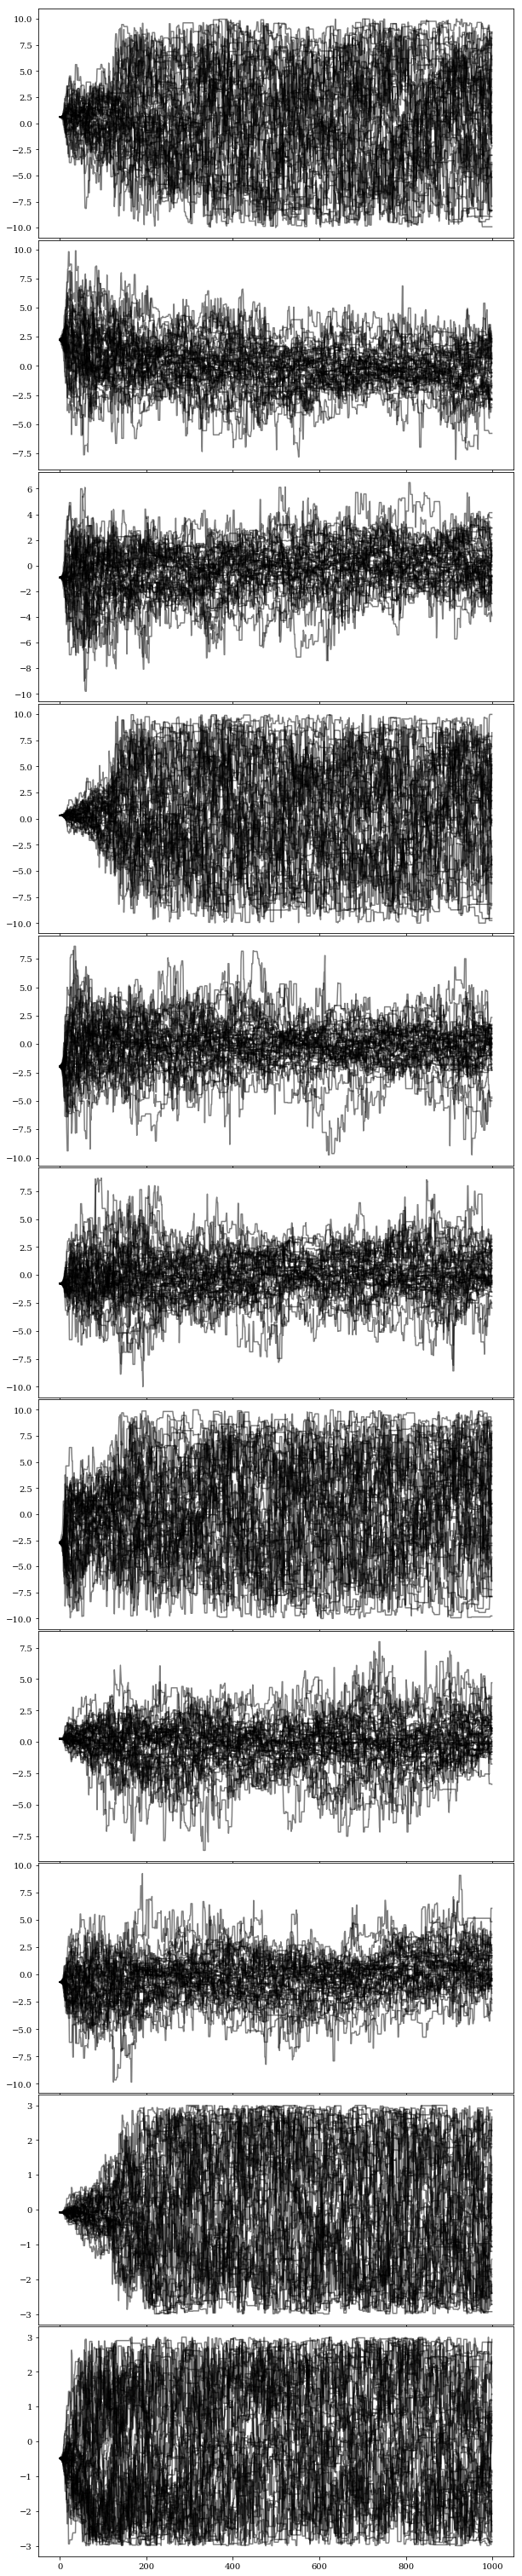

In [109]:
plotting.plot_chains(sampler.chain)

In [110]:
labels=[]; params_i = 0
for cmpt in np.arange(3).tolist()+['shd',]:
    for par in fid_pars['free_pars'][cmpt]:
        labels+=[func_labels[param_trans[cmpt][par][0]](label_dict[par], *param_trans[cmpt][par][1:3]),]
        params_i += 1;

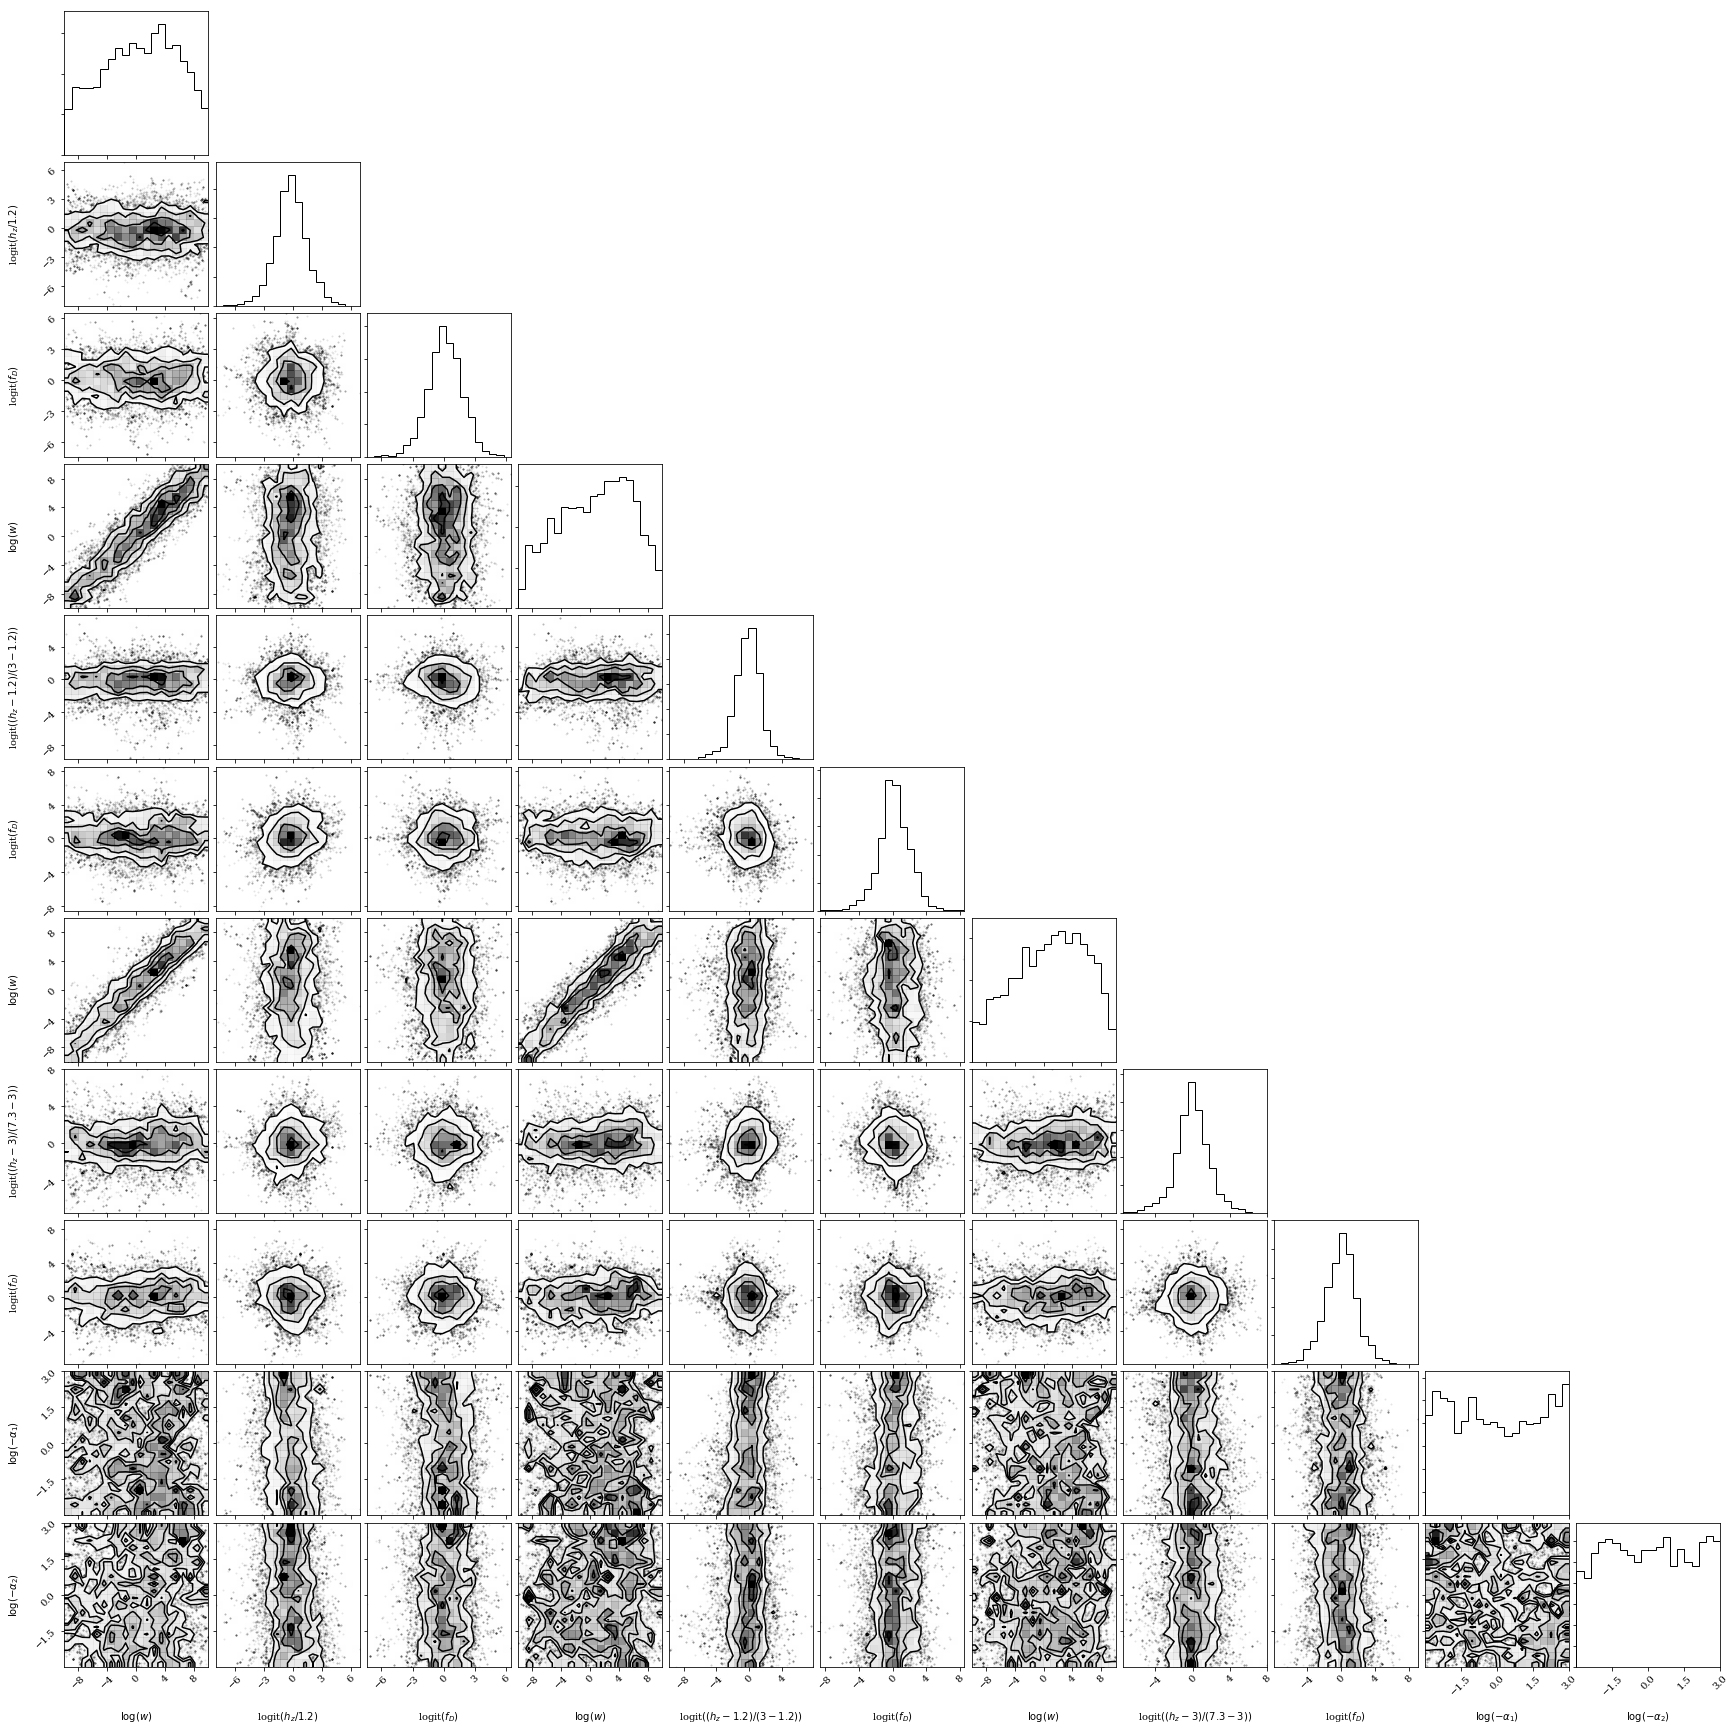

In [111]:
plotting.plot_corner(sampler.chain.copy(), truths=np.zeros(len(p0))-1000, labels=labels);

In [112]:
functions = []
for j in range(fid_pars['ncomponents']):
    for par in fid_pars['free_pars'][j]:
        functions.append(fid_pars['functions'][j][par])
for par in fid_pars['free_pars']['shd']:
    functions.append(fid_pars['functions']['shd'][par])

labels=[]; params_i = 0
for cmpt in np.arange(3).tolist()+['shd',]:
    for par in fid_pars['free_pars'][cmpt]:
        labels+=[label_dict[par],]
        params_i += 1;

In un-transformed space, fD, hz are uniformly distributed

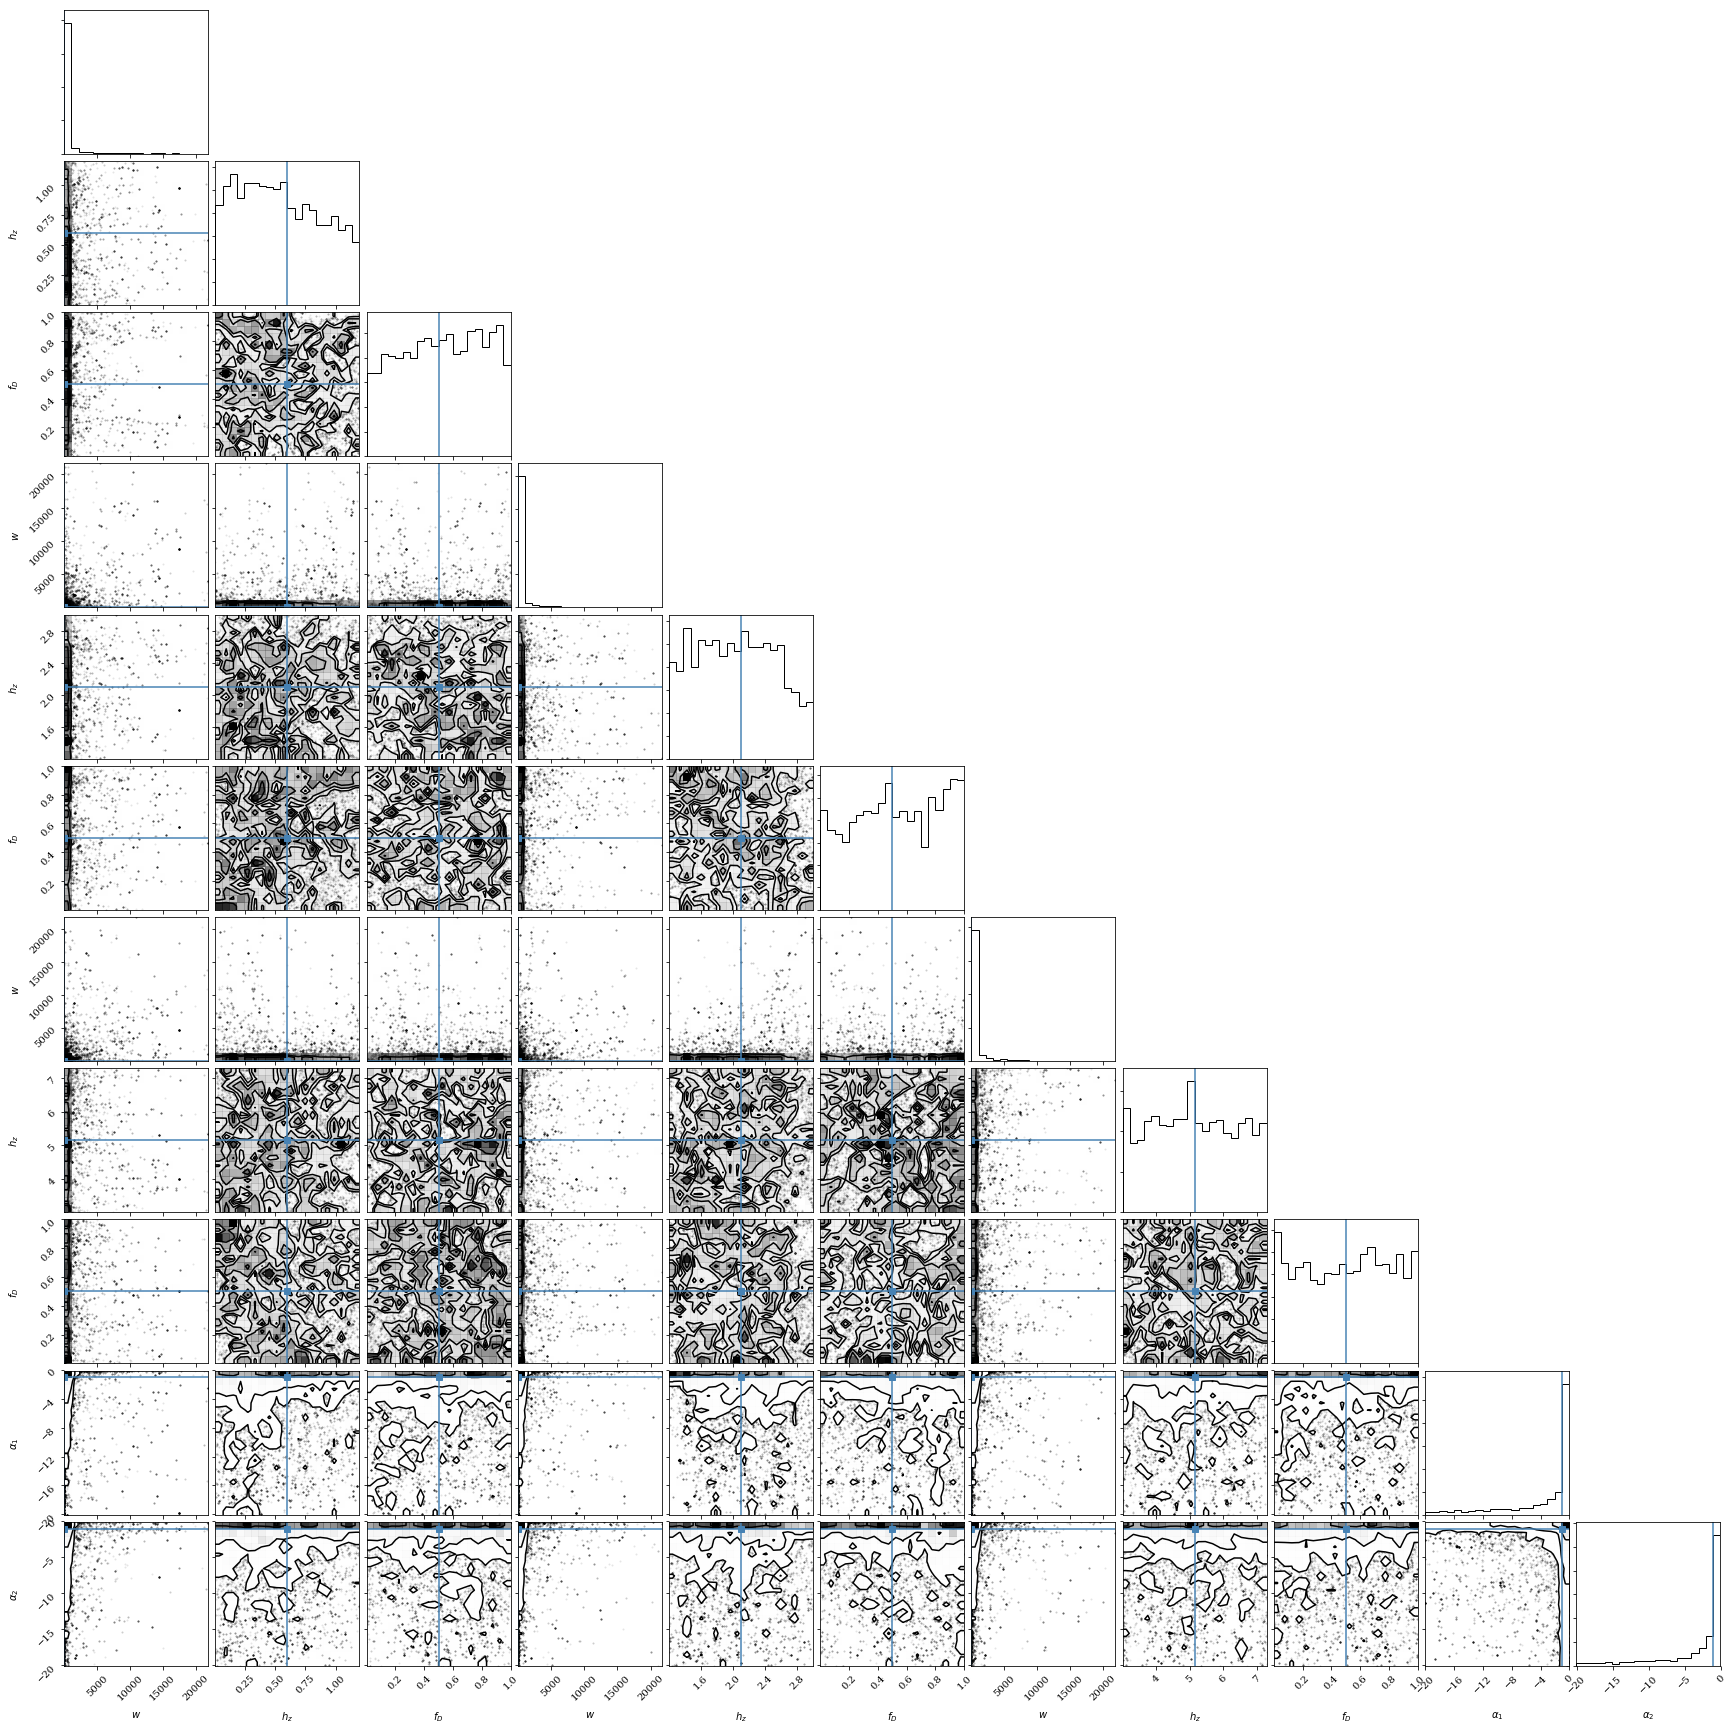

In [113]:
plotting.plot_corner(sampler.chain.copy(), functions=functions, labels=labels, truths=np.zeros(len(p0)))

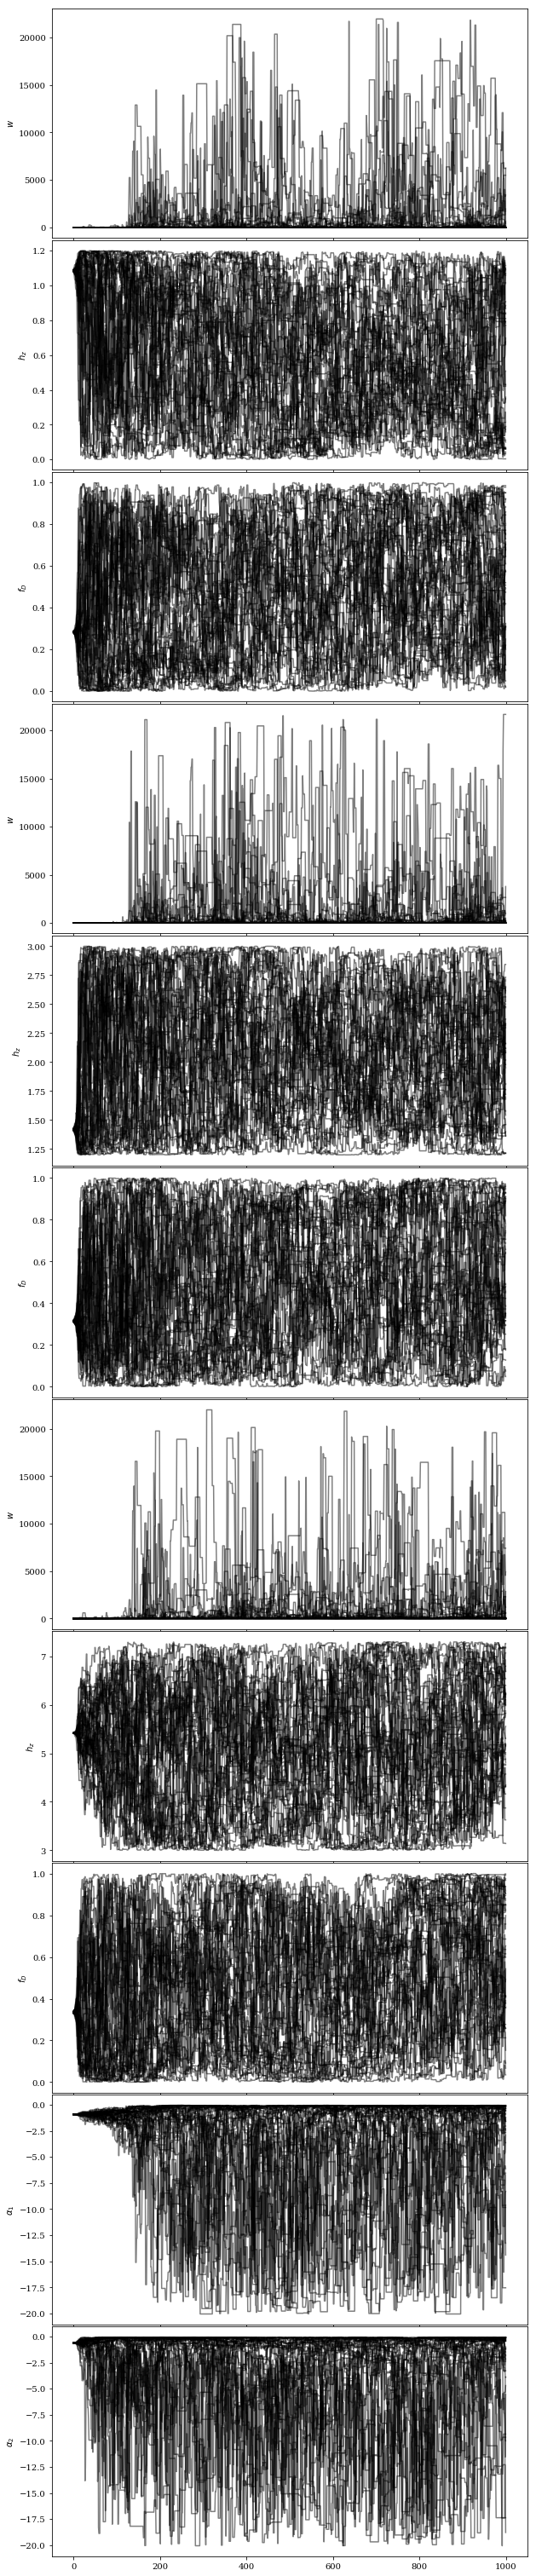

In [114]:
plotting.plot_chains(sampler.chain.copy(), functions=functions, labels=labels)